In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import sys
import torch
torch.set_default_tensor_type(torch.FloatTensor) # set the default to float32
import pyro
import pyro.distributions as dist
from pyro.infer import MCMC, NUTS
import time

from RCT_experiment import *
from Bayes_linear_regression import *
from plotting_functions import *
from MCMC_Bayesian_update import *
from utils import *


/Users/lucile/causal_info_gain/pjake/lib/python3.9/site-packages/torch/__init__.py:696: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)


### 1. Simulating the data

In [2]:
rng = np.random.RandomState(42)
show_plots = True

n_host_and_mirror = 1000
X0 = np.random.randint(0, 2, size=n_host_and_mirror)
X1 = np.random.normal(size=n_host_and_mirror)
x_distributions = {0: X0, 1: X1}

p_assigned_to_host = lambda X_1, X_2, T, eps: sigmoid(1 + X_1 - X_2 + T + eps)
p_assigned_to_cand2 = lambda X_1, X_2, T, eps: sigmoid(1 - 3*X_1 + eps)
X_rct, T_rct = generate_rct(n_host_and_mirror, x_distributions)

data_host, data_mirror = generate_host_and_mirror(X_rct, T_rct, p_assigned_to_cand2)
design_data_host = generate_design_matrix(data_host, power_x=1, power_x_t=1)
design_data_mirror = generate_design_matrix(data_mirror, power_x=1, power_x_t=1)

n_pre_cand2 = 500
pre_X_cand2, pre_T_cand2 = generate_rct(n_pre_cand2, x_distributions)
data_cand2 = generate_host2(pre_X_cand2, pre_T_cand2, p_assigned_to_cand2, n_cand2=100)
design_data_cand2 = generate_design_matrix(data_cand2, power_x=1, power_x_t=1)

outcome_function = lambda X, T, eps: 1 + 0.5 * X[:,0] + 2 * X[:,1] - 12 * T - 6* X[:,1]*T + eps # old version 1 / (1 + np.exp(-(1 + 2 * X[0] + 3 * X[1] + 5 * T - 6* X[1]*T eps)))
design_data_host = add_outcome(design_data_host, outcome_function)
design_data_mirror = add_outcome(design_data_mirror, outcome_function)
design_data_cand2 = add_outcome(design_data_cand2, outcome_function)

### 2. Simulating from prior and plotting
Note: I don't think this is the right way to compare if our estimates are getting better but it will do for now

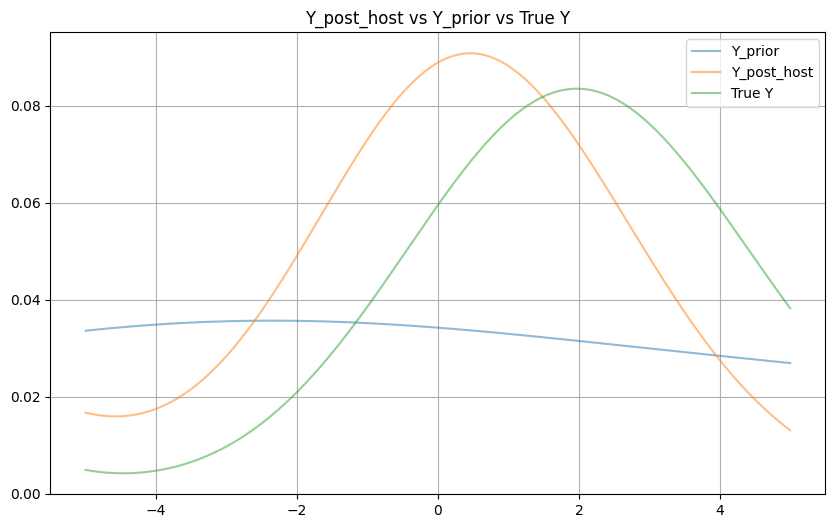

In [3]:
# Initialize prior parameters
post_mean = np.array([-0.5, 4.5, 7.5, -4.5, 1, 12])
beta_0, sigma_0_sq = post_mean, 1
prior_hyperparameters = {'beta_0': beta_0, 'sigma_0_sq': sigma_0_sq}
bayes_reg = BayesianLinearRegression(prior_hyperparameters)

### Bayesian update through host dataset
X_host, Y_host= design_data_host.drop(columns=['Y']), design_data_host['Y']
post_host_parameters = bayes_reg.fit(X_host, Y_host)

# Generate Y_prior
sigma_prior = 1  # Standard deviation for Y_prior
Y_prior = np.dot(X_host, beta_0) + np.random.normal(0, sigma_prior, len(X_host))

# Generate Y_post_host
beta_post_host = post_host_parameters['posterior_mean'].flatten()  # Extract posterior mean
Y_post_host = np.dot(X_host, beta_post_host) + np.random.normal(0, 1, len(X_host))  # Assuming standard deviation for Y_post_host is 1

plot_densities(Y_prior, Y_post_host, design_data_host['Y'], 
                names = ['Y_prior', 'Y_post_host', 'True Y'], 
                title = 'Y_post_host vs Y_prior vs True Y')


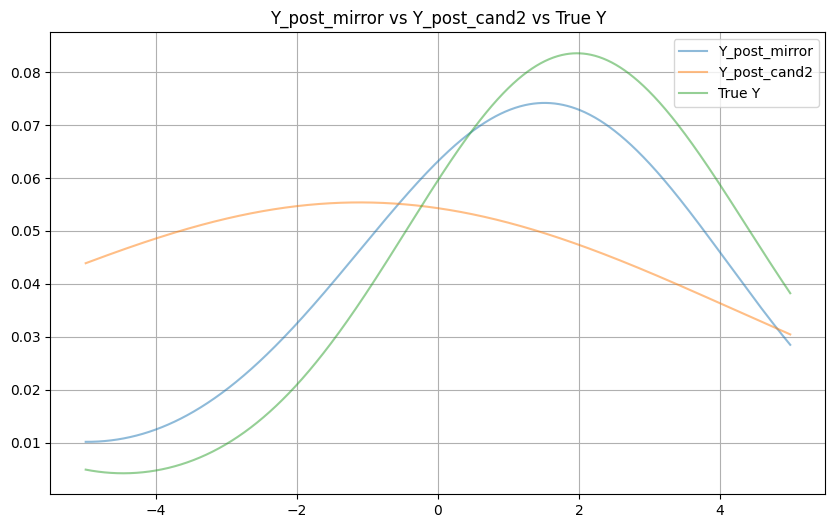

In [4]:
### Bayesian update through candidate datasets
sigma_cand = 1
prior_hyperparameters_cand = {'beta_0': beta_post_host, 'sigma_0_sq': sigma_cand}
bayes_reg_cand = BayesianLinearRegression(prior_hyperparameters_cand)

## With candidate = mirror dataset
X_mirror, Y_mirror = design_data_mirror.drop(columns=['Y']), design_data_mirror['Y']
post_mirror_parameters = bayes_reg.fit(X_mirror, Y_mirror)

# Generate Y_post_mirror
post_mirror_mean = post_mirror_parameters['posterior_mean'].flatten()  # Extract posterior mean
Y_post_mirror = np.dot(X_mirror, post_mirror_mean) + np.random.normal(0, 1, len(X_mirror))  # Assuming standard deviation for Y_post_host is 1

## With candidate = cand2 dataset
X_cand2, Y_cand2 = design_data_cand2.drop(columns=['Y']), design_data_cand2['Y']
post_cand2_parameters = bayes_reg.fit(X_cand2, Y_cand2)

# Generate Y_post_cand2
post_cand2_mean = post_cand2_parameters['posterior_mean'].flatten()  # Extract posterior mean
Y_post_cand2 = np.dot(X_cand2, post_cand2_mean) + np.random.normal(0, 1, len(X_cand2))  # Assuming standard deviation for Y_post_host is 1

plot_densities(Y_post_mirror, Y_post_cand2, design_data_host['Y'],
                names = ['Y_post_mirror', 'Y_post_cand2', 'True Y'], 
                title = 'Y_post_mirror vs Y_post_cand2 vs True Y')


In [5]:
#Number of samples used to estimate outer expectation
n_samples_for_expectation = 100
m_samples_for_expectation = int(np.ceil(np.sqrt(n_samples_for_expectation)))
# Incorporating sqrt constraint into MCMC samples
n_mcmc = (n_samples_for_expectation * (m_samples_for_expectation+1)) 

warmup_steps = 5
max_tree_depth = 7
sigma_rand_error = 1

## Bayesian update using the host dataset
mcmc_host = MCMC_Bayesian_update(X =X_host, Y= Y_host, model =model_normal,
            mu_0= beta_0, sigma_prior = sigma_prior, sigma_rand_error = sigma_rand_error,
            n_mcmc = n_mcmc, warmup_steps = warmup_steps, max_tree_depth=max_tree_depth)
mcmc_host.summary()

beta_post_host = pd.DataFrame(mcmc_host.get_samples())

#Shuffling to remove any dependence between adjacent samples
beta_post_host = beta_post_host.sample(frac = 1)

beta_post_host.head()
# We delete the column with the std
beta_post_host = beta_post_host.iloc[:, :-1] 

Sample: 100%|██████████| 1105/1105 [02:57,  6.24it/s, step size=2.46e-02, acc. prob=0.965]

Inference ran for 2.95 minutes

                mean       std    median      5.0%     95.0%     n_eff     r_hat
    beta_0     -0.44      0.99     -0.46     -2.05      1.21    806.70      1.00
    beta_1      4.48      1.01      4.44      2.77      6.02    918.05      1.00
    beta_2      7.47      1.00      7.45      5.93      9.15    796.33      1.00
    beta_3     -4.48      0.97     -4.45     -6.16     -2.97    717.93      1.00
    beta_4      0.98      0.97      0.97     -0.73      2.41    843.74      1.00
    beta_5      2.79      0.51      2.79      1.95      3.59   1647.28      1.00
     sigma      7.95      0.23      7.94      7.58      8.31   1136.54      1.00

Number of divergences: 0


### 3. Calculating EIG

In [6]:
from utils import samples_in_EIG_form,calc_EIG_observational
from scipy.stats import multivariate_normal

First, getting the model predictions and putting them in the correct form

In [7]:
Y_pred_candidate = predict_with_all_sampled_linear(beta_post_host, X_mirror)

pred_list = samples_in_EIG_form(Y_pred_candidate,n_samples_for_expectation,m_samples_for_expectation)
sigma = 1

In [8]:
calc_EIG_observational(pred_list,sigma)

1297.080353593277